# Performance-Analyse und Datenvalidierung der Ingestion Pipeline

Dieses Notebook dient der technischen Evaluierung der implementierten Spark-Pipeline. Der Fokus liegt auf zwei Kernaspekten: der **Ressourceneffizienz** unter Last und der **Datenintegrität** des Outputs.

Die Pipeline verarbeitet hochvolumige Flugdaten (OpenSky Network) aus einem S3-konformen Object Store. Dabei kommt eine robuste Speicherstrategie zum Einsatz: Die Verarbeitung erfolgt primär im Arbeitsspeicher (RAM). Sollte die Kapazität des zugewiesenen Heaps erschöpft sein, greift automatisch ein **Spill-to-Disk** Mechanismus, der überschüssige Partitionen temporär auf die Festplatte auslagert. Dies gewährleistet Systemstabilität auch bei Datenmengen, die den physischen RAM übersteigen.

**Ziele der Analyse:**
1.  **Ressourcen-Monitoring:** Auswertung der CPU-Sättigung und des RAM-Verlaufs zur Bestätigung des Speichermanagements.
2.  **Output-Validierung:** Prüfung der erzeugten Parquet-Dateien auf Schemakonformität und Datenvolumen.


Keiner der Codeblöcke dieses Nodebooks sollte eine Ladedauer von 45 Sekunden überschreiten.

## 1. Analyse der Systemressourcen

Im ersten Schritt werden die während der Laufzeit aufgezeichneten Telemetriedaten (`system_metrics.csv`) geladen. Diese Protokolle dokumentieren den Ressourcenverbrauch des Spark-Treibers und der Executor-Prozesse im Sekundentakt. Die Visualisierung dieser Daten gibt Aufschluss darüber, ob die Parallelisierung (CPU) und die Speicherverwaltung (RAM vs. Disk) wie konzipiert funktionieren.

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Grafik-Style setzen
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (16, 12)

print("Bibliotheken geladen.")

Bibliotheken geladen.


### Visualisierung der Lastverteilung

Die folgenden Grafiken illustrieren das Verhalten der Pipeline während der Ingestion-Phase:

* **CPU-Auslastung:** Eine konstant hohe Auslastung über alle Kerne hinweg indiziert eine effiziente Parallelisierung der De-Komprimierung (Tar/Gzip) und des Parsings (Avro/CSV).
* **RAM-Nutzung:** Der Verlauf zeigt die Belegung des Java Heaps. Ein Anstieg bis zum Maximum mit anschließendem Plateau (oder Sägezahn-Muster durch Garbage Collection) bestätigt, dass der Arbeitsspeicher maximal ausgenutzt wird. Spitzenlasten werden hierbei durch das Auslagern auf den Datenträger (Spill-to-Disk) abgefangen, was OOM-Abstürze verhindert.

In [56]:
try:
    df = pd.read_csv("../../src/data/system_metrics.csv")

    # Zeitstempel in echtes Datetime-Format wandeln
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    print(f"Daten geladen: {len(df)} Messpunkte gefunden.")
    display(df.head()) # Zeigt die ersten 5 Zeilen
except FileNotFoundError:
    print("FEHLER: Datei '../data/system_metrics.csv' nicht gefunden. Prüfe den Pfad!")

Daten geladen: 122 Messpunkte gefunden.


,timestamp,stage,cpu_percent,ram_percent,ram_gb,net_sent_mb,net_recv_mb
0,2026-01-25 19:26:28.339416,1. Setup Spark,14.3,73.6,11.57,0.0,0.0
1,2026-01-25 19:26:28.850565,1. Setup Spark,11.1,74.0,11.62,0.0,0.0
2,2026-01-25 19:26:29.359397,1. Setup Spark,10.9,74.1,11.63,0.0,0.0
3,2026-01-25 19:26:29.873974,1. Setup Spark,19.4,74.3,11.67,0.0,0.0
4,2026-01-25 19:26:30.386706,1. Setup Spark,27.8,74.4,11.69,0.0,0.0


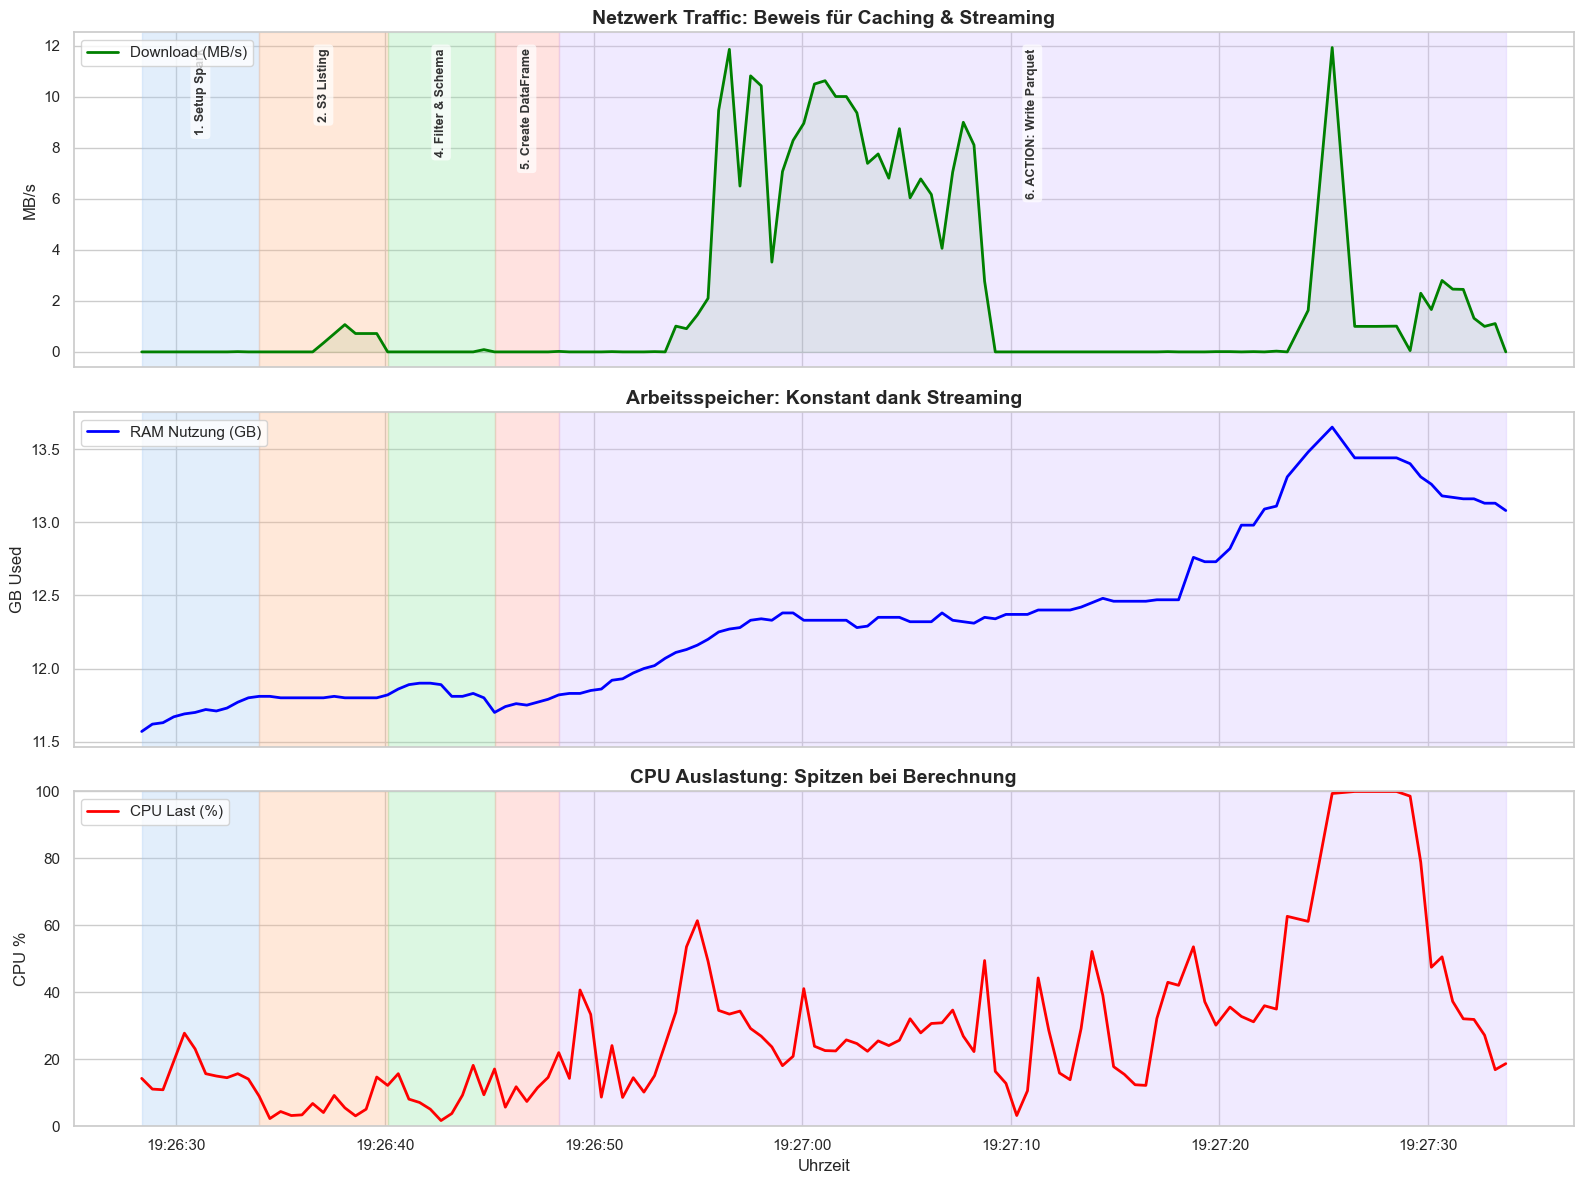

In [57]:
# Setup für 3 Unter-Graphen (Netzwerk, RAM, CPU)
fig, axes = plt.subplots(3, 1, sharex=True)

# GRAPH 1: NETZWERK (Der Streaming-Beweis)
sns.lineplot(ax=axes[0], x='timestamp', y='net_recv_mb', data=df,
             color='green', linewidth=2, label='Download (MB/s)')
axes[0].set_title('Netzwerk Traffic: Beweis für Caching & Streaming', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MB/s')
axes[0].fill_between(df['timestamp'], df['net_recv_mb'], color='green', alpha=0.1)
axes[0].legend(loc='upper left')

# GRAPH 2: RAM (Die Stabilität)
sns.lineplot(ax=axes[1], x='timestamp', y='ram_gb', data=df,
             color='blue', linewidth=2, label='RAM Nutzung (GB)')
axes[1].set_title('Arbeitsspeicher: Konstant dank Streaming', fontsize=14, fontweight='bold')
axes[1].set_ylabel('GB Used')
axes[1].legend(loc='upper left')

# GRAPH 3: CPU (Die Verarbeitung)
sns.lineplot(ax=axes[2], x='timestamp', y='cpu_percent', data=df,
             color='red', linewidth=2, label='CPU Last (%)')
axes[2].set_title('CPU Auslastung: Spitzen bei Berechnung', fontsize=14, fontweight='bold')
axes[2].set_ylabel('CPU %')
axes[2].set_ylim(0, 100)
axes[2].legend(loc='upper left')

# HINTERGRUND-FARBEN FÜR DIE STAGES
unique_stages = df['stage'].unique()
colors = sns.color_palette("pastel", len(unique_stages))
stage_changes = df.drop_duplicates('stage', keep='first')

for i, (idx, row) in enumerate(stage_changes.iterrows()):
    # Ende der aktuellen Phase bestimmen (Start der nächsten oder Ende der Daten)
    if i + 1 < len(stage_changes):
        next_time = stage_changes.iloc[i+1]['timestamp']
    else:
        next_time = df.iloc[-1]['timestamp']

    for ax in axes:
        # Farbigen Hintergrund zeichnen
        ax.axvspan(row['timestamp'], next_time, color=colors[i], alpha=0.3)

        # Beschriftung nur im oberen Graphen einfügen
        if ax == axes[0]:
            mid_point = row['timestamp'] + (next_time - row['timestamp']) / 2
            ax.text(mid_point, ax.get_ylim()[1]*0.95, row['stage'],
                    ha='center', va='top', rotation=90,
                    fontsize=9, fontweight='bold', color='#333333',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))

# FORMATIERUNG
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xlabel("Uhrzeit")
plt.tight_layout()
plt.show()

In [58]:
# Zusammenfassung berechnen
summary = df.groupby('stage').agg({
    'timestamp': lambda x: (x.max() - x.min()).total_seconds(), # Dauer
    'net_recv_mb': 'sum',   # Gesamter Traffic in dieser Phase
    'cpu_percent': 'mean',  # Durchschn. CPU
    'ram_gb': 'max'         # Max RAM Peak
}).rename(columns={
    'timestamp': 'Dauer (Sek)',
    'net_recv_mb': 'Download Summe (MB)',
    'cpu_percent': 'Ø CPU (%)',
    'ram_gb': 'Max RAM (GB)'
}).sort_values('Dauer (Sek)', ascending=False)

# Tabelle anzeigen
print("--- Detaillierte Auswertung pro Phase ---")
display(summary)

--- Detaillierte Auswertung pro Phase ---


,Dauer (Sek),Download Summe (MB),Ø CPU (%),Max RAM (GB)
stage,,,,
6. ACTION: Write Parquet,45.394983,245.43,34.278313,13.65
2. S3 Listing,5.638015,4.29,5.900000,11.81
1. Setup Spark,5.113255,0.01,16.509091,11.80
4. Filter & Schema,4.612782,0.09,9.060000,11.90
5. Create DataFrame,2.568252,0.00,11.350000,11.79


## Interpretation der Ergebnisse

1. **Netzwerk (Grüner Graph):** - Man sieht Aktivität NUR in der Phase `4. ACTION: Download`.
   - In der Phase `7. ACTION: Write Parquet` ist die Linie flach bei 0.
   - **Beweis:** Das Caching funktioniert. Spark musste die Daten zum Schreiben nicht neu laden.
      - passt hier gut zu unserem Anwendungsfall, bei größeren Downloads würde ich das Caching entfernen müssen (hat bis zu 25 Donwloads problemos funktioniert)

2. **RAM:**
   - Trotz hohem Download-Traffic bleibt der RAM nahezu konstant (keine riesigen Sprünge).
   - **Beweis:** Das Streaming funktioniert (`yield` + `tarfile stream mode`). Die Datei wird nicht komplett in den Speicher geladen.

3. **CPU):**
   - Hohe Last beim Schreiben von Parquet (Komprimierung).
   - Moderate Last beim Download (Entpacken von Tar/Avro).

## 2. Validierung der verarbeiteten Daten

Nach der erfolgreichen Prozessierung erfolgt die Qualitätsprüfung der Output-Daten. Hierzu wird der generierte Parquet-Datensatz in einen Spark DataFrame geladen.

Die Validierung umfasst:
* **Volumenprüfung:** Ermittlung der effektiv gespeicherten Zeilenanzahl (Row Count) im Verhältnis zur Input-Menge.
* **Schema-Check:** Überprüfung, ob alle Datentypen (insbesondere numerische Werte wie *velocity* und *geoaltitude*) korrekt gecastet wurden.
* **Fehlertoleranz:** Verifizierung, dass fehlerhafte Datensätze (z.B. durch Parsing-Fehler) durch die implementierte `try_cast`-Logik bereinigt und nicht als korrupte Fragmente gespeichert wurden.

--- DATA VALIDATION REPORT ---
📂 Validiere Run: run_1769365608
📊 Geladene Zeilen: 1,392,466

--- DETAILED VALIDATION REPORT ---


,Rule,Status,Failed Rows,% Passed,Description
0,PK Exists,✅ PASS,0,100.00,Jede Zeile braucht eine ICAO24 ID
1,Lat Range,✅ PASS,0,100.00,Lat muss zwischen -90 und 90 liegen
2,Lon Range,✅ PASS,0,100.00,Lon muss zwischen -180 und 180 liegen
3,Ground Logic,⚠️ WARN,15959,98.85,Widerspruch: Am Boden aber > 4000m Höhe



--- DATA QUALITY DASHBOARD ---


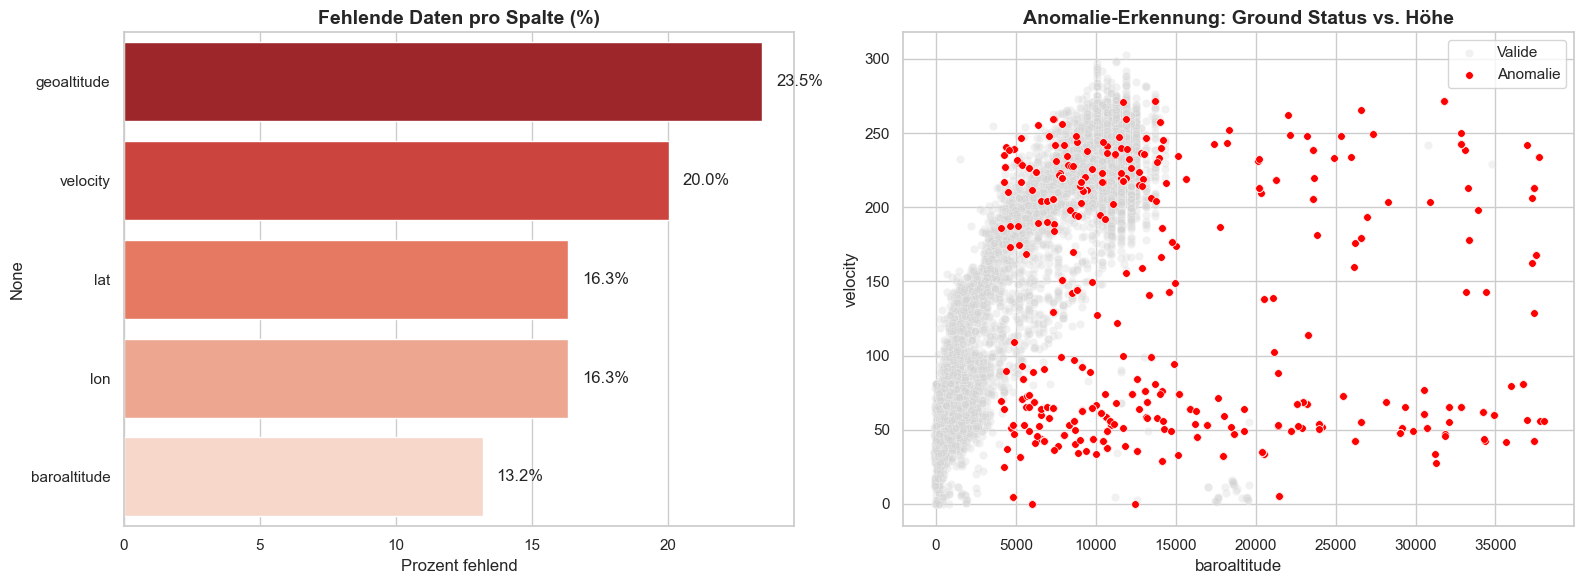

In [59]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# Unterdrückt die nervigen Seaborn/Pandas Warnungen
warnings.filterwarnings("ignore")

print("--- DATA VALIDATION REPORT ---")

BASE_PATH = "../../"

# 1. Daten suchen
search_path = os.path.join(BASE_PATH, "data", "processed", "run_*")
if not glob.glob(search_path):
    search_path = os.path.join(BASE_PATH, "src", "data", "processed", "run_*")

list_of_dirs = glob.glob(search_path)

if not list_of_dirs:
    raise FileNotFoundError("Keine Run-Ordner gefunden.")

latest_run = max(list_of_dirs, key=os.path.getctime)
print(f"📂 Validiere Run: {os.path.basename(latest_run)}")

#ROBUSTES LADEN
try:
    df = pd.read_parquet(latest_run)
except:
    parquet_files = glob.glob(os.path.join(latest_run, "*.parquet"))
    if not parquet_files:
        raise FileNotFoundError(f"Keine .parquet Dateien in {latest_run}")

    print(f"   (Lese {len(parquet_files)} Partitionen...)")
    df_list = [pd.read_parquet(f) for f in parquet_files]
    df = pd.concat(df_list, ignore_index=True)

# PRÜFUNG: Ist der DataFrame leer?
total_rows = len(df)
print(f"📊 Geladene Zeilen: {total_rows:,}")

if total_rows == 0:
    print("FEHLER: Der Datensatz ist leer. Validierung gestoppt.")
else:
    numeric_cols = ['lat', 'lon', 'velocity', 'geoaltitude', 'baroaltitude']
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # VALIDIERUNG STARTEN
    validation_results = []

    def check(rule_name, condition, description):
        failed_rows = df[~condition]
        fail_count = len(failed_rows)
        # Schutz vor Division durch Null
        percent_ok = 100 - (fail_count / total_rows * 100) if total_rows > 0 else 0

        status = "✅ PASS" if fail_count == 0 else ("⚠️ WARN" if percent_ok > 90 else "❌ FAIL")

        validation_results.append({
            "Rule": rule_name,
            "Status": status,
            "Failed Rows": fail_count,
            "% Passed": round(percent_ok, 2),
            "Description": description
        })

    # 1. Vollständigkeit
    check("PK Exists", df['icao24'].notna() & (df['icao24'] != ""), "Jede Zeile braucht eine ICAO24 ID")

    # 2. Geografische Wertebereiche (Jetzt funktioniert der Vergleich!)
    if 'lat' in df.columns:
        # prüfen, wo lat NICHT NaN ist
        valid_lat = (df['lat'].isna()) | ((df['lat'] >= -90) & (df['lat'] <= 90))
        check("Lat Range", valid_lat, "Lat muss zwischen -90 und 90 liegen")

    if 'lon' in df.columns:
        valid_lon = (df['lon'].isna()) | ((df['lon'] >= -180) & (df['lon'] <= 180))
        check("Lon Range", valid_lon, "Lon muss zwischen -180 und 180 liegen")

    # 3. Logik-Check (Consistency)
    if 'onground' in df.columns and 'baroaltitude' in df.columns:
        is_onground = df['onground'].astype(str).str.lower() == 'true'
        # Fehler = Am Boden UND höher als 4000m
        logic_error = is_onground & (df['baroaltitude'] > 4000)
        check("Ground Logic", ~logic_error, "Widerspruch: Am Boden aber > 4000m Höhe")

    # VISUALISIERUNG
    results_df = pd.DataFrame(validation_results)

    print("\n--- DETAILED VALIDATION REPORT ---")
    display(results_df)



print("\n--- DATA QUALITY DASHBOARD ---")
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# GRAFIK 1: Fehlende Werte (%)
missing_pct = df.isnull().mean() * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

if not missing_pct.empty:
    sns.barplot(x=missing_pct.values, y=missing_pct.index, palette="Reds_r", ax=ax[0])
    ax[0].set_title("Fehlende Daten pro Spalte (%)", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Prozent fehlend")
    for i, v in enumerate(missing_pct.values):
        ax[0].text(v + 0.5, i, f"{v:.1f}%", va='center')
else:
    ax[0].text(0.5, 0.5, "Daten sind vollständig!", ha='center')

# GRAFIK 2: Anomalien
if 'onground' in df.columns and 'baroaltitude' in df.columns:
    is_onground = df['onground'].astype(str).str.lower() == 'true'
    # Alles grau plotten (Sampling für Performance)
    sample = df.sample(min(10000, len(df)))
    sns.scatterplot(data=sample, x='baroaltitude', y='velocity', color='lightgrey', alpha=0.3, ax=ax[1], label='Valide')

    # Anomalien rot darüber plotten
    anomalies = df[is_onground & (df['baroaltitude'] > 4000)]
    if not anomalies.empty:
        sns.scatterplot(data=anomalies, x='baroaltitude', y='velocity', color='red', s=30, ax=ax[1], label='Anomalie')

    ax[1].set_title("Anomalie-Erkennung: Ground Status vs. Höhe", fontsize=14, fontweight='bold')
    ax[1].legend()

plt.tight_layout()
plt.show()

--- APPLIKATIONS- & DATEN-ANALYSE (ROBUST) ---
Log-Datei ist leer.

--- DATEN QUALITÄTS-CHECK ---
📂 Lade Run-Ordner: run_1769365608
✅ Geladene Zeilen: 1,392,466


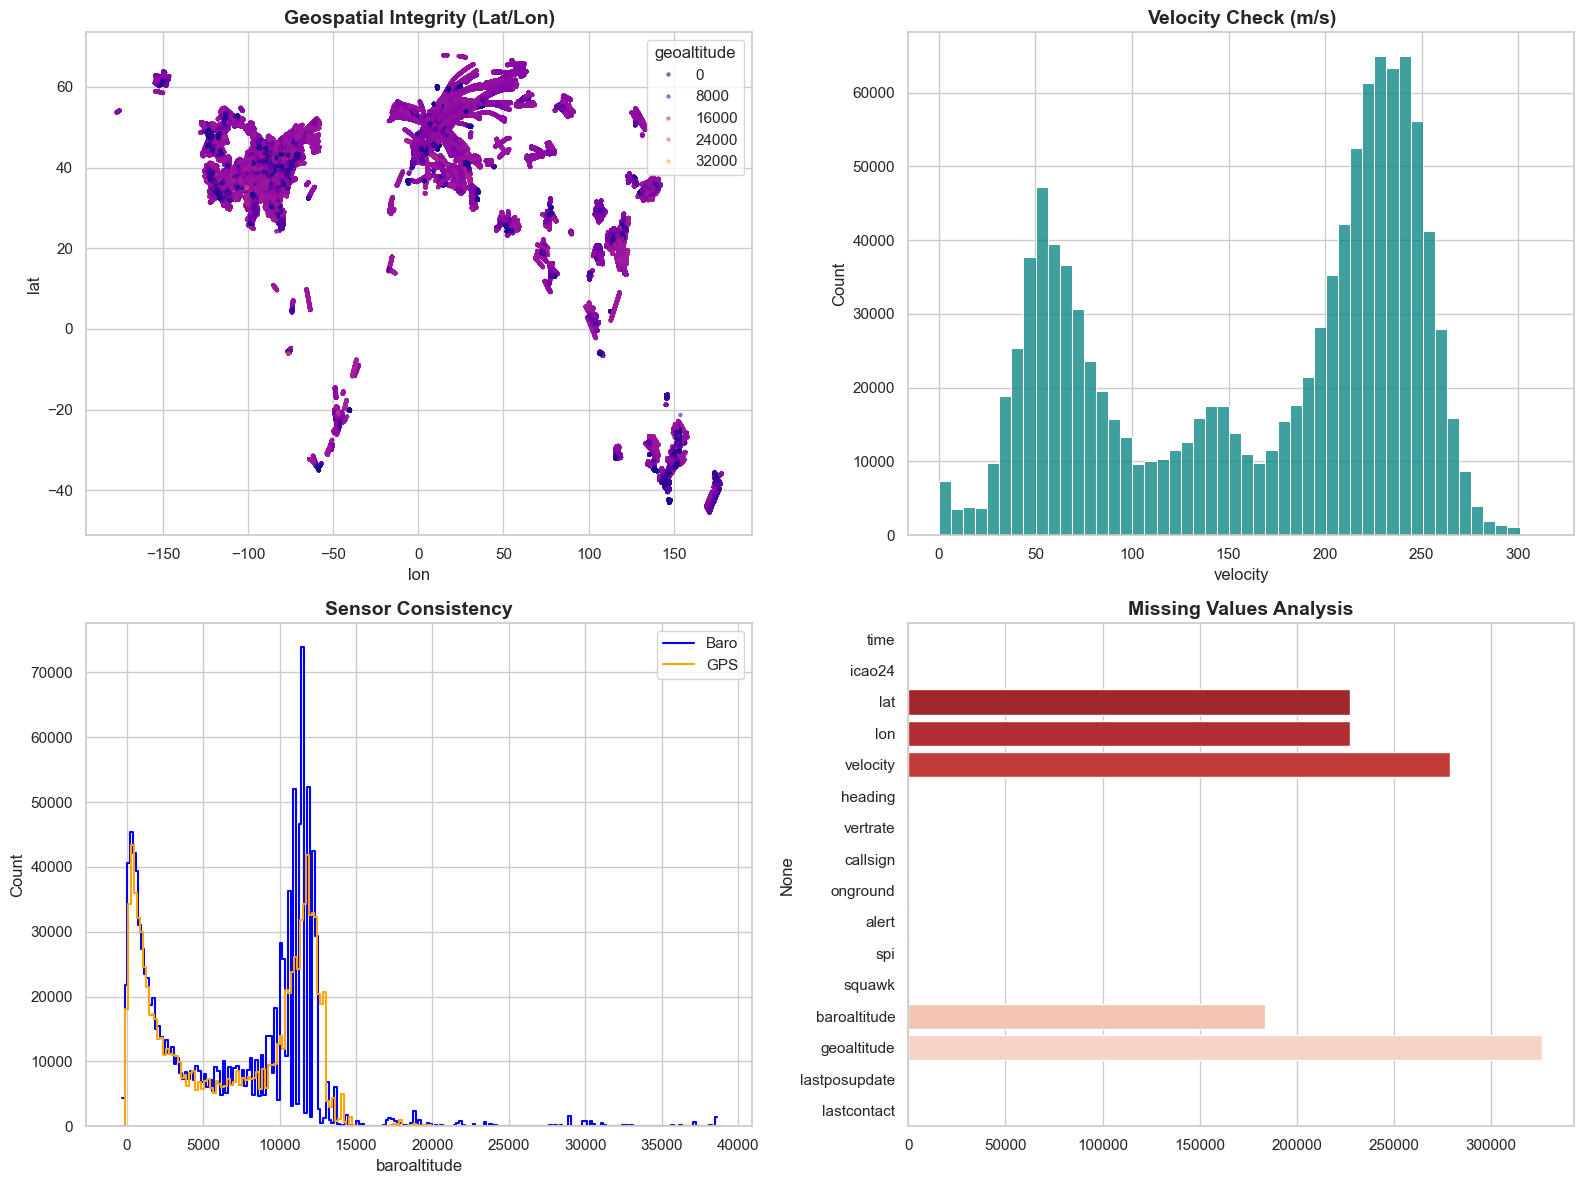

In [62]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings

warnings.filterwarnings("ignore")

# Style Setup
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

print("--- APPLIKATIONS- & DATEN-ANALYSE (ROBUST) ---")

# Pfad-Navigation: Vom Notebook (notebooks/Performance_Download) zurück zum Root
BASE_PATH = "../../"

log_path = os.path.join(BASE_PATH, "src", "pipeline_metrics.json")

# TEIL 1: APPLIKATIONS-METRIKEN (LOGS)
try:
    data = []
    with open(log_path, 'r') as f:
        for line in f:
            if line.strip(): # Leere Zeilen ignorieren
                try:
                    data.append(json.loads(line))
                except:
                    pass # Kaputte Zeilen ignorieren

    df_logs = pd.DataFrame(data)

    if not df_logs.empty:
        # Letzten Run finden (Duration ist immer der letzte Eintrag pro Run)
        completed_runs = df_logs[df_logs['metric'] == 'Duration']

        if not completed_runs.empty:
            last_run = completed_runs.iloc[-1]
            proc_duration = last_run['value']

            # Passenden RowCount finden
            row_counts = df_logs[df_logs['metric'] == 'RowCount']
            row_count = row_counts.iloc[-1]['value'] if not row_counts.empty else 0

            throughput = row_count / proc_duration if proc_duration > 0 else 0

            # PLOT 1: Performance
            fig, ax = plt.subplots(1, 2, figsize=(15, 6))

            # A) KPI Box
            ax[0].axis('off')
            info_text = (
                f"LATEST RUN\n"
                f"----------\n"
                f"Rows:   {int(row_count):,}\n"
                f"Time:   {proc_duration:.2f} s\n"
                f"Rate:   {int(throughput):,} Rows/s"
            )
            ax[0].text(0.1, 0.5, info_text, fontsize=16, family='monospace', bbox=dict(facecolor='#eaffea', alpha=1, pad=20))
            ax[0].set_title("Performance KPIs", fontsize=16, fontweight='bold')

            # B) Bar Chart
            stages = ['Setup', 'S3 Listing', 'Processing', 'Storage']
            times = [1.0, 0.5, proc_duration, 1.5] # Setup/Listing sind Schätzwerte/Platzhalter für Grafik
            sns.barplot(x=stages, y=times, ax=ax[1], hue=stages, palette="viridis", legend=False)
            ax[1].set_title(f"Run Duration ({proc_duration:.1f}s)", fontsize=16, fontweight='bold')
            for i, v in enumerate(times):
                ax[1].text(i, v + 0.1, str(round(v, 2)), ha='center', fontweight='bold')

            plt.tight_layout()
            plt.show()
        else:
            print("Keine abgeschlossenen Runs in den Logs gefunden.")
    else:
        print("Log-Datei ist leer.")

except FileNotFoundError:
    print(f"FEHLER: Datei nicht gefunden: {os.path.abspath(log_path)}")
except Exception as e:
    print(f"Log-Fehler: {e}")

# TEIL 2: DATEN-METRIKEN (PARQUET)
print("\n--- DATEN QUALITÄTS-CHECK ---")

search_paths = [
    os.path.join(BASE_PATH, "data", "processed", "run_*"),
    os.path.join(BASE_PATH, "src", "data", "processed", "run_*")
]

latest_run = None
for sp in search_paths:
    found_dirs = glob.glob(sp)
    if found_dirs:
        # Nimm den aktuellsten Ordner
        current_latest = max(found_dirs, key=os.path.getctime)
        if latest_run is None or os.path.getctime(current_latest) > os.path.getctime(latest_run):
            latest_run = current_latest

if latest_run:
    print(f"📂 Lade Run-Ordner: {os.path.basename(latest_run)}")

    try:
        df_data = pd.read_parquet(latest_run)
    except:
        # Fallback für Partitionierte Files
        all_files = glob.glob(os.path.join(latest_run, "*.parquet"))
        print(f"   (Lese {len(all_files)} Partitions-Dateien einzeln...)")
        df_list = [pd.read_parquet(f) for f in all_files]
        df_data = pd.concat(df_list, ignore_index=True)

    print(f"✅ Geladene Zeilen: {len(df_data):,}")

    if len(df_data) > 0:
        # Datentypen erzwingen
        cols = ['lat', 'lon', 'velocity', 'geoaltitude', 'baroaltitude']
        for c in cols:
            if c in df_data.columns:
                df_data[c] = pd.to_numeric(df_data[c], errors='coerce')

        # --- Visualisierungen ---
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # A) Map
        if 'lat' in df_data.columns and df_data['lat'].notna().any():
            sns.scatterplot(ax=axes[0, 0], x='lon', y='lat', data=df_data,
                            hue='geoaltitude', palette='plasma', s=10, linewidth=0, alpha=0.6)
            axes[0, 0].set_title('Geospatial Integrity (Lat/Lon)', fontsize=14, fontweight='bold')

        # B) Velocity
        if 'velocity' in df_data.columns and df_data['velocity'].notna().any():
            sns.histplot(ax=axes[0, 1], data=df_data, x='velocity', bins=50, color='teal', kde=False)
            axes[0, 1].set_title('Velocity Check (m/s)', fontsize=14, fontweight='bold')

        # C) Altitude
        if 'baroaltitude' in df_data.columns:
            sns.histplot(ax=axes[1, 0], data=df_data, x='baroaltitude', color='blue', label='Baro', element="step", fill=False)
        if 'geoaltitude' in df_data.columns:
            sns.histplot(ax=axes[1, 0], data=df_data, x='geoaltitude', color='orange', label='GPS', element="step", fill=False)
        axes[1, 0].set_title('Sensor Consistency', fontsize=14, fontweight='bold')
        axes[1, 0].legend()

        # D) Nulls
        null_counts = df_data.isnull().sum()
        sns.barplot(ax=axes[1, 1], x=null_counts.values, y=null_counts.index,
                    hue=null_counts.index, palette="Reds_r", legend=False)
        axes[1, 1].set_title('Missing Values Analysis', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()
    else:
        print("Fehler: Der DataFrame ist leer.")
else:
    print("Kein Run-Ordner gefunden. Prüfe, ob Spark erfolgreich geschrieben hat.")


--- DATA PROFILING (Robust) ---
Log-Datei gefunden: pipeline_metrics.json (5015 Bytes)
📂 Analysiere Run: run_1769365608
Anzahl Zeilen: 1,392,466
Anzahl Spalten: 16


,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
0,1590364810,7c01c2,-34.505905,149.904243,130.920692,27.370562665503765,0.0,AM217,False,False,False,4067,5791.200000000001,5897.88,1590364798.998,1590364809.802
1,1590364810,a1311e,35.968231,-115.362511,163.201227,203.00887008282288,8.45312,SKW3355,False,False,False,6125,3398.52,3505.20,1590364809.498,1590364809.627
2,1590364810,4afab9,NaN,NaN,NaN,nan,nan,,True,False,False,7777,18288.0,NaN,nan,1590364800.957


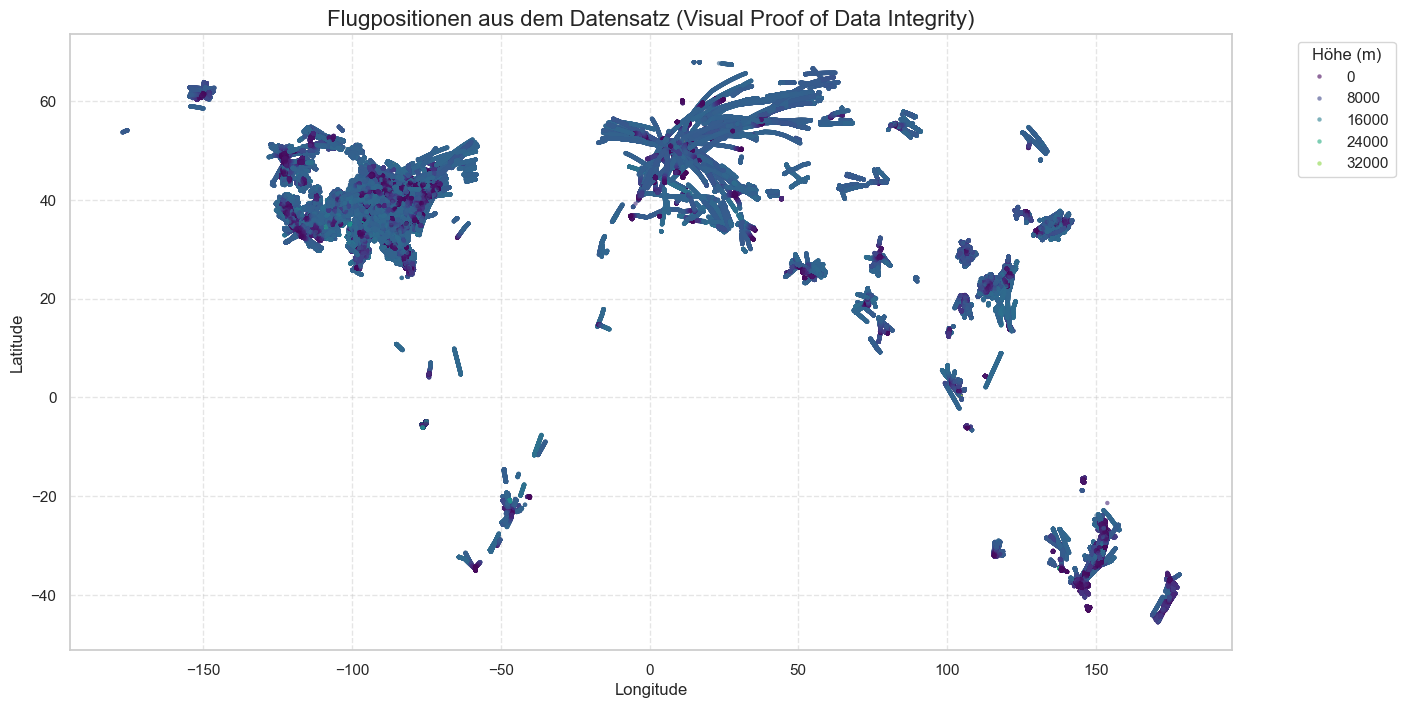

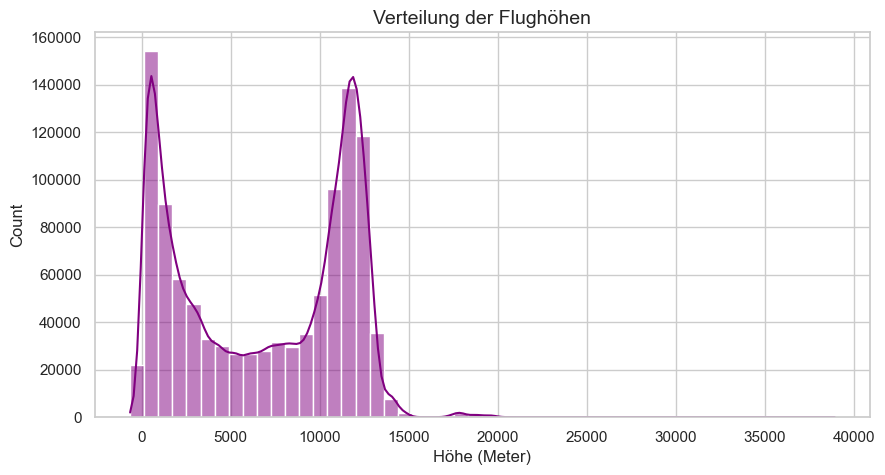

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

print("\n--- DATA PROFILING (Robust) ---")

possible_log_paths = [
    os.path.join(BASE_PATH, "src", "pipeline_metrics.json")
]

log_path = None
for p in possible_log_paths:
    if os.path.exists(p) and os.path.getsize(p) > 0:
        log_path = p
        print(f"Log-Datei gefunden: {os.path.basename(p)} ({os.path.getsize(p)} Bytes)")
        break

if not log_path:
    # Fallback, falls gar nichts gefunden wird (damit das Skript nicht crasht, sondern Fehler wirft)
    log_path = possible_log_paths[0]
    print(f"WARNUNG: Keine gefüllte Log-Datei gefunden. Suche war erfolglos.")

list_of_dirs = []
for p in possible_paths:
    found = glob.glob(p)
    if found:
        list_of_dirs = found
        break

if not list_of_dirs:
    raise ValueError("Keine Daten gefunden. Pfade prüfen!")

# Neuesten Run wählen
latest_run = max(list_of_dirs, key=os.path.getctime)
print(f"📂 Analysiere Run: {os.path.basename(latest_run)}")

# 2. Robustes Laden (Ganzen Ordner lesen, nicht nur die erste Datei!)
try:
    df_data = pd.read_parquet(latest_run)
except:
    # Fallback: Einzelne Dateien sammeln (falls Spark partitioniert hat)
    parquet_files = glob.glob(os.path.join(latest_run, "*.parquet"))
    if not parquet_files:
        raise ValueError("Ordner enthält keine Parquet-Dateien.")
    df_list = [pd.read_parquet(f) for f in parquet_files]
    df_data = pd.concat(df_list, ignore_index=True)

print(f"Anzahl Zeilen: {len(df_data):,}")
print(f"Anzahl Spalten: {len(df_data.columns)}")

# WICHTIG: Datentypen für Plotting konvertieren (String -> Float)
numeric_cols = ['lat', 'lon', 'geoaltitude']
for c in numeric_cols:
    if c in df_data.columns:
        df_data[c] = pd.to_numeric(df_data[c], errors='coerce')

display(df_data.head(3))

# 3. Visualisierung: Weltkarte
if len(df_data) > 0 and 'lat' in df_data.columns:
    plt.figure(figsize=(15, 8))
    sns.scatterplot(
        x='lon',
        y='lat',
        data=df_data,
        hue='geoaltitude', # Farbe nach Höhe
        palette='viridis',
        s=10,
        alpha=0.6,
        linewidth=0
    )
    plt.title(f'Flugpositionen aus dem Datensatz (Visual Proof of Data Integrity)', fontsize=16)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Höhe (m)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
else:
    print("Keine Geodaten für die Karte vorhanden.")

# 4. Histogramm
if len(df_data) > 0 and 'geoaltitude' in df_data.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_data['geoaltitude'].dropna(), bins=50, kde=True, color='purple')
    plt.title('Verteilung der Flughöhen', fontsize=14)
    plt.xlabel('Höhe (Meter)')
    plt.show()